In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

from qiskit_algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

In [4]:
SEED = 123
qasm_sim = AerSimulator()

# Dataset

        test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0              50      0      0            0                    0          0   
1              50      1      0            0                    0          0   
2              50      0      1            0                    0          0   
3              50      1      0            0                    0          0   
4              50      1      0            0                    0          0   
...           ...    ...    ...          ...                  ...        ...   
278842          0      0      0            0                    0          0   
278843          0      0      0            0                    0          0   
278844          0      0      0            0                    0          0   
278845          0      0      0            0                    0          0   
278846          0      0      0            0                    0          0   

        corona_result  age_60_and_above

Text(0.5, 1.0, 'COVID dataset (first two features)')

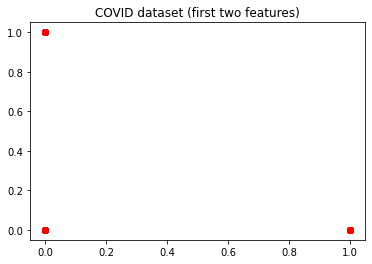

In [54]:
df = pd.read_csv("..\data\corona_tested_individuals_ver_006.english.csv")
print(df)

y = df[["corona_result"]].to_numpy()

x = df[["test_date","cough","fever","sore_throat","shortness_of_breath","head_ache","age_60_and_above","gender","test_indication"]].to_numpy()

#x = df.to_numpy()

# Normalization
for i in range(0,9):
    x[:,i] = x[:,i] / (np.max(x[:,i])-np.min(x[:,i]))

num_classes = 3
num_features = 9

idxs0 = np.where(y==0)
print(idxs0)

idxs1 = np.where(y==1)
print(idxs1)
x_blue = x[idxs0[0],:]
x_red = x[idxs1[0],:]

print(x_blue)

plt.scatter(x_blue[:,0], x_blue[:,1], c='b', label="class 0")
plt.scatter(x_red[:,0], x_red[:,5], c='r', label="class 1")
plt.title("COVID dataset (first two features)")
#plt.legend()

In [55]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 223077
Test set size:  55770


# Data embedding circuits

C:\Users\Reza\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


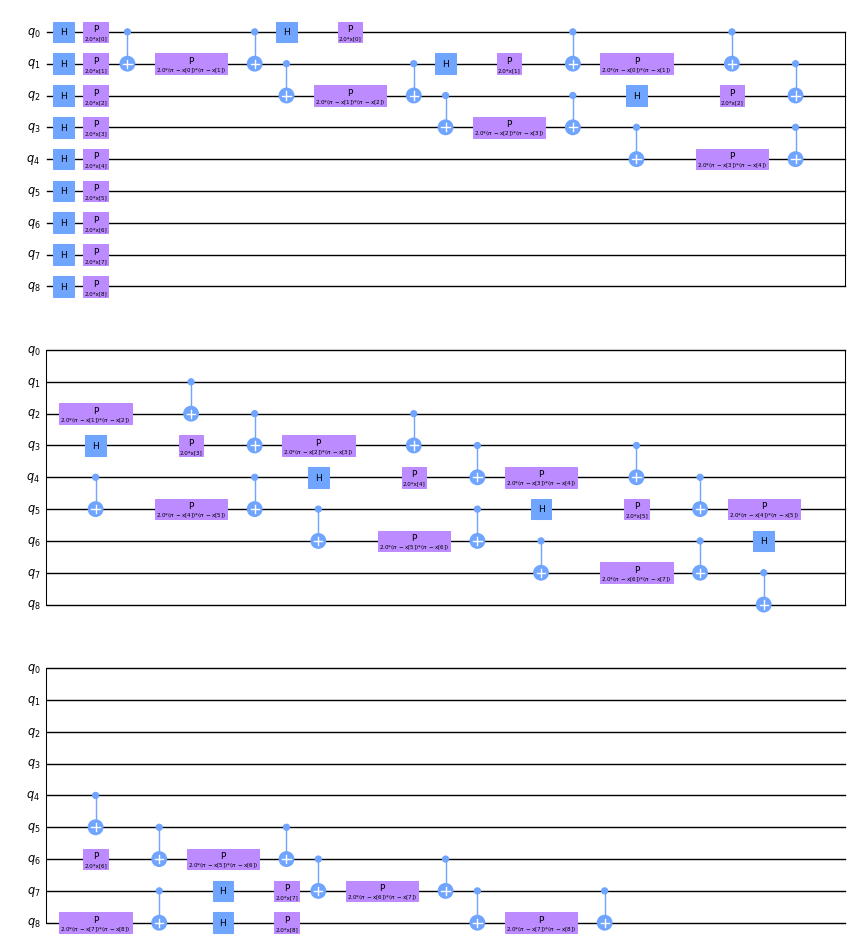

In [56]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

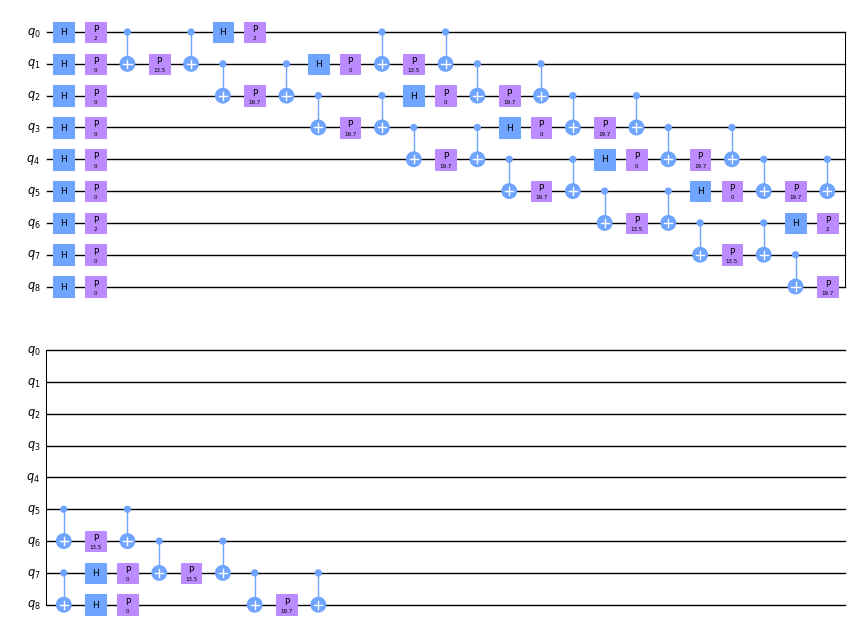

In [57]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}).decompose().draw('mpl', scale=0.7)

# Anstaz

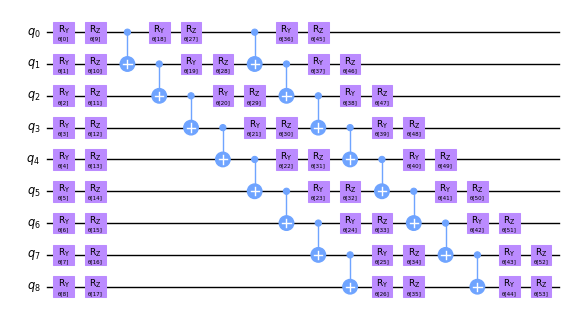

In [58]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

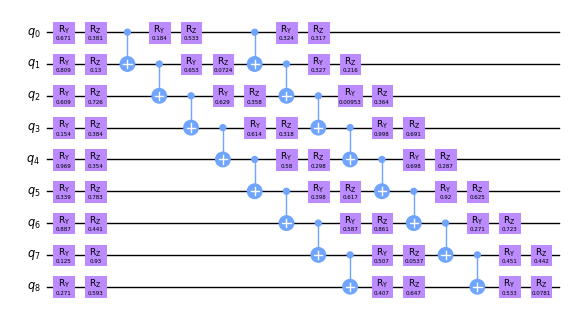

In [59]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

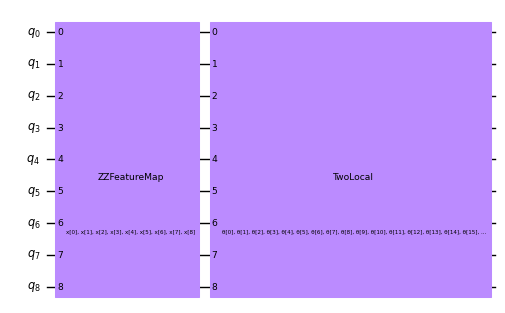

In [60]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

# Primitives

For info, see https://docs.quantum.ibm.com/run/primitives

In [61]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

# Quantum Neural Network

## SamplerQNN

In [11]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [12]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [13]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

### Forward pass

In [14]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 100 samples: (100, 2)
Output of the forward pass for first sample: [0.28320312 0.71679688]


### Backward pass

In [15]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")


Output shape for 100 samples: (100, 2, 12)
Output of the backward pass for first sample: [[ 0.09326172 -0.05517578 -0.28955078 -0.109375   -0.03173828  0.11865234
  -0.17041016  0.07617188 -0.07275391  0.          0.00732422  0.00732422]
 [-0.09326172  0.05517578  0.28955078  0.109375    0.03173828 -0.11865234
   0.17041016 -0.07617188  0.07275391  0.         -0.00732422 -0.00732422]]


## EstimatorQNN

In [16]:
obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

Parity observable: ZZ
First qubit observable: IZ


In [17]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

### Forward pass

In [18]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 100 samples: (100, 1)
Output of the forward pass for first sample: [-0.45507812]


### Backward pass

In [19]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 100 samples: (100, 1, 12)
Output of the backward pass for first sample: [[ 0.20214844 -0.07910156 -0.5546875  -0.24023438 -0.04882812  0.25585938
  -0.33984375  0.13378906 -0.10742188 -0.04296875  0.02246094 -0.02050781]]


# Train a Neural Network Classifier

In [20]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 0 converted to [1 0]
Label 1 converted to [0 1]


In [21]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [22]:
max_itr = 10
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train, y_train_1h)

Text(0.5, 1.0, 'Training loss')

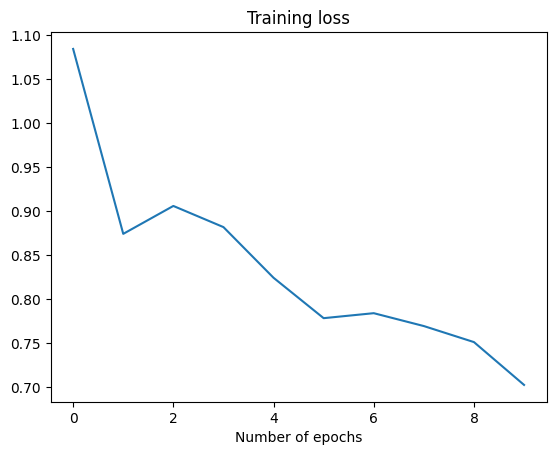

In [23]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [24]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.7125
Score on the test set 0.55


In [25]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [26]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [27]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

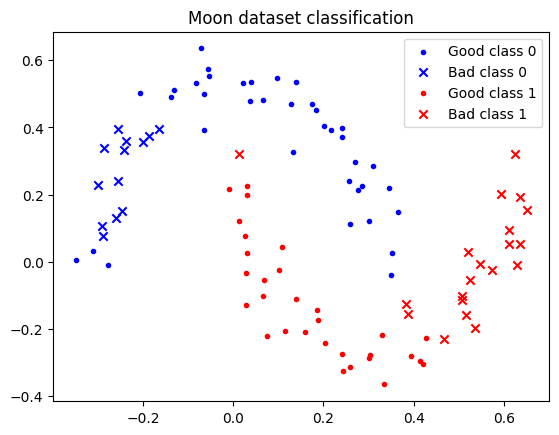

In [28]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Moon dataset classification")
plt.legend()